In [1]:
import sys
import numpy as np
import cv2 as cv
from IPython import display

# Virtual display
from pyvirtualdisplay import Display

import time
import PIL.Image
import io    

# python3.9
# opencv 4.6.0 source build

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = io.BytesIO()
    ima = PIL.Image.fromarray(a).save(f, fmt)
    return f.getvalue()

# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(frame, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 2)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    #cv.rectangle(frame, (left, top - round(1.3*labelSize[1])), (left + round(1.3*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

    
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(frame, classIds[i], confidences[i], left, top, left + width, top + height)
        
def showmov(file, did):
    net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
    #net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
    #net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)
    net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)

    vdisplay = Display(visible=0, size=(800, 600))
    vdisplay.start()

    cap = cv.VideoCapture(file)
    out = cv.VideoWriter('objdet_' + file,
                         cv.VideoWriter_fourcc(*'avc1'),
                         cap.get(cv.CAP_PROP_FPS),
                         (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv.CAP_PROP_FRAME_HEIGHT)))
                        ) 
    if not out.isOpened():
        print('File open failed!')
        cap.release()
        sys.exit()
        
    first = True
    while cap.isOpened():
        
        # get frame from the video
        hasFrame, frame = cap.read()
       
        # Stop the program if reached end of video
        if not hasFrame:
            print("Done processing !!!")
            cap.release()
            break
    
        # Create a 4D blob from a frame.
        blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
    
        # Sets the input to the network
        net.setInput(blob)
        
        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))
    
        # Remove the bounding boxes with low confidence
        postprocess(frame, outs)
    
        # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
        t, _ = net.getPerfProfile()
        label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
        cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
        
        out.write(frame.astype(np.uint8))
    
        im_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        if (first):
            display.display(display.Image(data=showarray(im_rgb)), display_id=did)
            first = False
        else:
            display.update_display(display.Image(data=showarray(im_rgb)), display_id=did)

    out.release()
    vdisplay.stop()




# 누구나 할 수있는 Object detaction 예제

In [18]:
display.Video('tennis_cut.mp4')

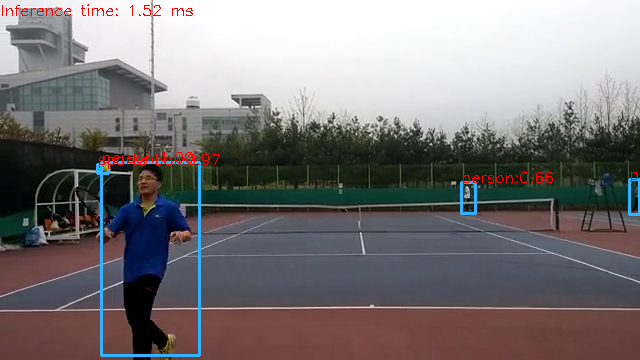

Done processing !!!


In [4]:
showmov('tennis_cut.mp4', 'tennis')

In [20]:
display.Video('objdet_tennis_cut.mp4')

In [23]:
display.Video('battle_cut.mp4')

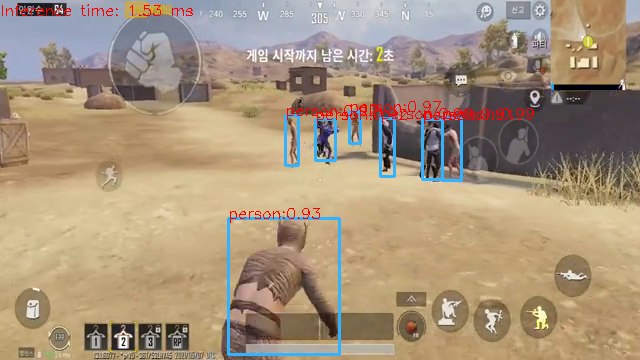

Done processing !!!


In [24]:
showmov('battle_cut.mp4', 'battle')

# 누구나 할 수 있는 OCR 예제

<img src='battlegrounds.png'>

이제 모든 곳이 배틀그라운드

이제 모든 곳이 인공지능개발



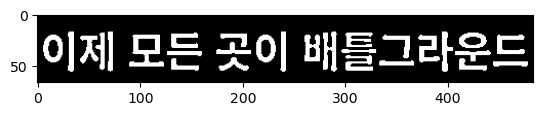

In [25]:
import ipywidgets as widgets
import cv2
import matplotlib.pyplot  as plt
org = cv2.imread("battlegrounds.png", cv2.IMREAD_COLOR)
invert = cv2.bitwise_not(org)
#plt.imshow(invert, cmap='gray')
gray = cv2.cvtColor(invert, cv2.COLOR_BGR2GRAY)
#plt.imshow(gray, cmap='gray')
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
#plt.imshow(img_blurred, cmap='gray')
img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)
plt.imshow(img_blur_thresh, cmap='gray')
import pytesseract
#text = pytesseract.image_to_string('battlegrounds.png', lang='kor', config='--psm 4 --oem 1')
#text = pytesseract.image_to_string(img_blurred, lang='kor', config='--psm 4 --oem 1')
text = pytesseract.image_to_string(img_blur_thresh, lang='kor', config='--psm 4 --oem 1')
print(text)
text = text.replace('배틀그라운드', '인공지능개발')
print(text)